In [ ]:
!pip install mlflow

In [9]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df = pd.read_csv('data/sentiment_analysis.csv')
df.head()

,clean_comment,category
0,"mean, hit way different knowing conspiracy shi...",0
1,nazi west,0
2,bad thats,-1
3,im daft punk wanted everyone else wanted model...,-1
4,best rapper 2k25,1


In [11]:
df['clean_comment'] = df['clean_comment'].fillna('')

In [15]:
# Initialize your vectorizer
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer()

# --- FIX: REMOVE .toarray() ---
# X will now be a sparse matrix (e.g., scipy.sparse.csr_matrix)
X = vectorizer.fit_transform(df['clean_comment'])


y = df['category']

In [16]:
X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 692742 stored elements and shape (119456, 49935)>

In [17]:
X.shape

(119456, 49935)

In [18]:
y

0         0
1         0
2        -1
3        -1
4         1
         ..
119451    1
119452   -1
119453    0
119454   -1
119455    0
Name: category, Length: 119456, dtype: int64

In [19]:
y.shape

(119456,)

Step 2: Set up the MLflow tracking server locally
# To CONTNUE RUN THIS COMMAND IN TERMINAL!
mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 127.0.0.1 --port 5000

In [20]:
import mlflow

# Set local MLflow tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [21]:
# Set or create an experiment - not using the default one
mlflow.set_experiment("RF Baseline")

<Experiment: artifact_location='/home/user/Youtube-Comments-Sentiment-Analysis/mlruns/1', creation_time=1752824706919, experiment_id='1', last_update_time=1752931004477, lifecycle_stage='active', name='RF Baseline', tags={}>

In [22]:
# Test mlflow

with mlflow.start_run():
    mlflow.log_param("param1", 12)
    mlflow.log_metric("metric1", 0.29)

🏃 View run puzzled-bee-388 at: http://127.0.0.1:5000/#/experiments/1/runs/c2b66e5d135c405d9d24899433f8a56b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


2025/07/19 17:12:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Baseline_TrainTestSplit at: http://127.0.0.1:5000/#/experiments/1/runs/92d948d3c0924511ba4ef66801595976
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
Accuracy: 0.5045203415369162


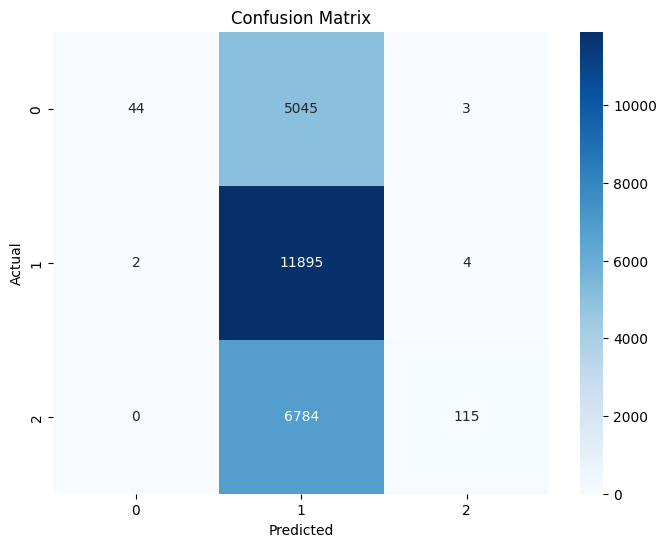

In [23]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

       # Save and log confusion matrix
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Save and log dataset
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("dataset.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.96      0.01      0.02      5092
           0       0.50      1.00      0.67     11901
           1       0.94      0.02      0.03      6899

    accuracy                           0.50     23892
   macro avg       0.80      0.34      0.24     23892
weighted avg       0.73      0.50      0.35     23892

